# Dissatisfaction Data Analysis_3

Analyze the topic of dissatisfaction of each group.

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import numpy.linalg as LA
import random as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import itertools
from tqdm import tqdm_notebook as tqdm

data = pd.read_csv('gender_data_12.csv', encoding="utf-8")

Since what we are interested in is the stationary mechanism of posting, we analyzed data from when the service was stable.

In [2]:
num = sum(data["created_at_unix"]<400)
data = data[num:].reset_index(drop=True)
data["created_at_unix"] = data["created_at_unix"]-400
data.head()

,Unnamed: 0,post_id,user_id,category,sub_category,company,branch,product,text,created_at,created_at_unix,gender,birth,label
0,16298,3842076,8104,外食・店舗,レストラン,ロイヤルホスト,横須賀市佐原店,席の案内基準,平日ランチタイムの利用客が、毎回90%以上中高年女性なので、席の選択が可能な時は、男性客に選...,2016-04-21 14:01:30.472191,0.017917,男,1963.0,11
1,16299,3842199,7618,業界・業種,運輸業,千葉運輸支局,軽自動車問い合わせ窓口,担当者の電話対応,黒ナンバーの車の廃車に関する問い合わせに男性の職員が出たが、口調が上からな感じで横柄な態度を...,2016-04-21 14:18:54.013804,0.030000,女,1986.0,3
2,16300,3842225,104953,暮らし・住まい,キッチン用品・食器・調理器具,NaN,NaN,お箸,女性用のお箸はどうして男性ものより短く出来てるんですかぁ?\n私は細くて男性ものぐらいの長さ...,2016-04-21 14:22:22.307534,0.032407,女,1963.0,5
3,16301,3842337,118578,人間関係,職場,NaN,NaN,職場の人間関係,職場の男性、若い女性にばかり優しく自分には冷たい。\n話もアニメやゲーム好きで合わないのもあるが。,2016-04-21 14:39:22.150780,0.044213,女,1981.0,3
4,16302,3842545,128998,医療・福祉,病院,高砂市民病院,NaN,男性看護師?,看護師かは、はっきりしないが男性スタッフが増えている。女性は髪をまとめているが男性はボサボサ...,2016-04-21 15:10:58.489131,0.066157,女,1971.0,4


## LDA
1. $N$ : Number of words. Poisson distribution with intensity $\xi$.
2. $\Theta$ : Distribution of Topic. Dirichelt distribution with parameter $\alpha$.
3. Each word $w_1, \dots, w_N$ is generated as below:  
a) $z_n$ : Topic of the n-th word, which is generated by Multinomial distribution with parameter $\Theta$.  
b) $w_n$ : The n-th word which is generated some probability $p(w_n|Z_n, \beta)$ where $\beta$ is parameter.

In [3]:
import MeCab
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from collections import defaultdict

# MeCabオブジェクトの生成
mecab = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd -Owakati")

# データの準備
textDeta = data["text"].tolist()

texts = []
for line in textDeta:
    text = []
    node = mecab.parseToNode(line.strip())
    while node:
        fields = node.feature.split(",")
        if fields[0] == '名詞' :#or fields[0] == '動詞' or fields[0] == '形容詞' or fields[0] == '副詞':
            text.append(node.surface)
        node = node.next
    texts.append(text)
    
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=2) # 出現文書数/全文書数が 0.5 以下
corpus = [dictionary.doc2bow(text) for text in texts]
print('vocab size: ', len(dictionary))

vocab size:  8446


In [4]:
for word, id_ in dictionary.token2id.items():
    print(f"id: {id_}, 単語: {word}, 出現ドキュメント数: {dictionary.dfs[id_]}, 出現回数: {dictionary.cfs[id_]}")

id: 0, 単語: 90%, 出現ドキュメント数: 2, 出現回数: 2
id: 1, 単語: ランチタイム, 出現ドキュメント数: 2, 出現回数: 2
id: 2, 単語: 中高年, 出現ドキュメント数: 11, 出現回数: 12
id: 3, 単語: 以上, 出現ドキュメント数: 129, 出現回数: 142
id: 4, 単語: 利用客, 出現ドキュメント数: 5, 出現回数: 6
id: 5, 単語: 可能, 出現ドキュメント数: 18, 出現回数: 18
id: 6, 単語: 女性, 出現ドキュメント数: 3349, 出現回数: 4378
id: 7, 単語: 女性客, 出現ドキュメント数: 38, 出現回数: 40
id: 8, 単語: 席, 出現ドキュメント数: 122, 出現回数: 169
id: 9, 単語: 平日, 出現ドキュメント数: 23, 出現回数: 26
id: 10, 単語: 時, 出現ドキュメント数: 490, 出現回数: 569
id: 11, 単語: 毎回, 出現ドキュメント数: 57, 出現回数: 64
id: 12, 単語: 男性客, 出現ドキュメント数: 51, 出現回数: 57
id: 13, 単語: 真ん中, 出現ドキュメント数: 13, 出現回数: 14
id: 14, 単語: 選択, 出現ドキュメント数: 26, 出現回数: 31
id: 15, 単語: そう, 出現ドキュメント数: 353, 出現回数: 384
id: 16, 単語: ナンバー, 出現ドキュメント数: 2, 出現回数: 2
id: 17, 単語: フリ, 出現ドキュメント数: 7, 出現回数: 7
id: 18, 単語: 上, 出現ドキュメント数: 145, 出現回数: 152
id: 19, 単語: 口調, 出現ドキュメント数: 17, 出現回数: 18
id: 20, 単語: 問い合わせ, 出現ドキュメント数: 5, 出現回数: 7
id: 21, 単語: 回答, 出現ドキュメント数: 15, 出現回数: 18
id: 22, 単語: 感じ, 出現ドキュメント数: 246, 出現回数: 268
id: 23, 単語: 態度, 出現ドキュメント数: 160, 出現回数: 187
id: 24, 単語: 担当者, 出現ドキュメント数: 13, 

id: 1964, 単語: 否定, 出現ドキュメント数: 17, 出現回数: 17
id: 1965, 単語: 呼び方, 出現ドキュメント数: 6, 出現回数: 7
id: 1966, 単語: 大激怒, 出現ドキュメント数: 2, 出現回数: 2
id: 1967, 単語: 嫌悪感, 出現ドキュメント数: 8, 出現回数: 8
id: 1968, 単語: 扱い, 出現ドキュメント数: 60, 出現回数: 62
id: 1969, 単語: 根本的, 出現ドキュメント数: 5, 出現回数: 5
id: 1970, 単語: 玩具, 出現ドキュメント数: 6, 出現回数: 7
id: 1971, 単語: 簡単, 出現ドキュメント数: 50, 出現回数: 52
id: 1972, 単語: 違和感, 出現ドキュメント数: 57, 出現回数: 58
id: 1973, 単語: 量販店, 出現ドキュメント数: 3, 出現回数: 3
id: 1974, 単語: 参加費, 出現ドキュメント数: 3, 出現回数: 4
id: 1975, 単語: 街コン, 出現ドキュメント数: 5, 出現回数: 6
id: 1976, 単語: 高, 出現ドキュメント数: 18, 出現回数: 18
id: 1977, 単語: か等, 出現ドキュメント数: 2, 出現回数: 2
id: 1978, 単語: 大分, 出現ドキュメント数: 5, 出現回数: 5
id: 1979, 単語: 本当, 出現ドキュメント数: 56, 出現回数: 59
id: 1980, 単語: 皆んな, 出現ドキュメント数: 3, 出現回数: 3
id: 1981, 単語: 箇所, 出現ドキュメント数: 12, 出現回数: 14
id: 1982, 単語: 組み合わせ, 出現ドキュメント数: 6, 出現回数: 6
id: 1983, 単語: 重要視, 出現ドキュメント数: 2, 出現回数: 2
id: 1984, 単語: おまけ, 出現ドキュメント数: 11, 出現回数: 11
id: 1985, 単語: 中国人, 出現ドキュメント数: 7, 出現回数: 8
id: 1986, 単語: 半端ない, 出現ドキュメント数: 10, 出現回数: 10
id: 1987, 単語: 喧嘩, 出現ドキュメント数: 14, 出現回数: 14
id: 

id: 2963, 単語: 半開き, 出現ドキュメント数: 3, 出現回数: 3
id: 2964, 単語: 妄想, 出現ドキュメント数: 3, 出現回数: 3
id: 2965, 単語: 表情, 出現ドキュメント数: 9, 出現回数: 9
id: 2966, 単語: プレッシャー, 出現ドキュメント数: 7, 出現回数: 7
id: 2967, 単語: コメンテーター, 出現ドキュメント数: 13, 出現回数: 15
id: 2968, 単語: レベル, 出現ドキュメント数: 59, 出現回数: 67
id: 2969, 単語: ヤツ, 出現ドキュメント数: 9, 出現回数: 9
id: 2970, 単語: ケア, 出現ドキュメント数: 6, 出現回数: 7
id: 2971, 単語: マッチョ, 出現ドキュメント数: 3, 出現回数: 3
id: 2972, 単語: 細, 出現ドキュメント数: 3, 出現回数: 3
id: 2973, 単語: 髪形, 出現ドキュメント数: 2, 出現回数: 2
id: 2974, 単語: 1週間, 出現ドキュメント数: 4, 出現回数: 4
id: 2975, 単語: さい, 出現ドキュメント数: 5, 出現回数: 5
id: 2976, 単語: 受信, 出現ドキュメント数: 2, 出現回数: 2
id: 2977, 単語: 拒否, 出現ドキュメント数: 10, 出現回数: 10
id: 2978, 単語: 日にち, 出現ドキュメント数: 2, 出現回数: 2
id: 2979, 単語: 返事, 出現ドキュメント数: 16, 出現回数: 17
id: 2980, 単語: ポケモン, 出現ドキュメント数: 13, 出現回数: 18
id: 2981, 単語: 分け, 出現ドキュメント数: 5, 出現回数: 7
id: 2982, 単語: 目印, 出現ドキュメント数: 2, 出現回数: 2
id: 2983, 単語: そっけ, 出現ドキュメント数: 4, 出現回数: 4
id: 2984, 単語: 医療, 出現ドキュメント数: 7, 出現回数: 7
id: 2985, 単語: 思いやり, 出現ドキュメント数: 8, 出現回数: 8
id: 2986, 単語: 気遣い, 出現ドキュメント数: 9, 出現回数: 9
id: 2987, 

id: 4463, 単語: 着付け, 出現ドキュメント数: 4, 出現回数: 5
id: 4464, 単語: 袴, 出現ドキュメント数: 3, 出現回数: 4
id: 4465, 単語: ダンス, 出現ドキュメント数: 12, 出現回数: 14
id: 4466, 単語: 組体操, 出現ドキュメント数: 5, 出現回数: 6
id: 4467, 単語: はめ, 出現ドキュメント数: 7, 出現回数: 7
id: 4468, 単語: 二重, 出現ドキュメント数: 3, 出現回数: 11
id: 4469, 単語: 分析, 出現ドキュメント数: 7, 出現回数: 8
id: 4470, 単語: 完了, 出現ドキュメント数: 2, 出現回数: 2
id: 4471, 単語: 客層, 出現ドキュメント数: 9, 出現回数: 10
id: 4472, 単語: 打ち, 出現ドキュメント数: 5, 出現回数: 6
id: 4473, 単語: 西友, 出現ドキュメント数: 2, 出現回数: 2
id: 4474, 単語: 東急, 出現ドキュメント数: 2, 出現回数: 2
id: 4475, 単語: 1000円カット, 出現ドキュメント数: 5, 出現回数: 6
id: 4476, 単語: 2000円, 出現ドキュメント数: 4, 出現回数: 5
id: 4477, 単語: 前髪, 出現ドキュメント数: 6, 出現回数: 8
id: 4478, 単語: 散髪, 出現ドキュメント数: 2, 出現回数: 2
id: 4479, 単語: お人好し, 出現ドキュメント数: 2, 出現回数: 2
id: 4480, 単語: しくじり先生, 出現ドキュメント数: 3, 出現回数: 4
id: 4481, 単語: 多額, 出現ドキュメント数: 3, 出現回数: 3
id: 4482, 単語: 美談, 出現ドキュメント数: 4, 出現回数: 4
id: 4483, 単語: 相席, 出現ドキュメント数: 2, 出現回数: 4
id: 4484, 単語: 前向き, 出現ドキュメント数: 2, 出現回数: 2
id: 4485, 単語: 安易, 出現ドキュメント数: 8, 出現回数: 8
id: 4486, 単語: 手軽, 出現ドキュメント数: 5, 出現回数: 5
id: 4487, 単語: 街頭, 

id: 5962, 単語: 発展途上国, 出現ドキュメント数: 4, 出現回数: 5
id: 5963, 単語: 週刊文春, 出現ドキュメント数: 6, 出現回数: 6
id: 5964, 単語: 剤, 出現ドキュメント数: 5, 出現回数: 5
id: 5965, 単語: 柔軟, 出現ドキュメント数: 3, 出現回数: 3
id: 5966, 単語: いたん, 出現ドキュメント数: 2, 出現回数: 2
id: 5967, 単語: 上下関係, 出現ドキュメント数: 4, 出現回数: 4
id: 5968, 単語: 直線, 出現ドキュメント数: 2, 出現回数: 2
id: 5969, 単語: 店名, 出現ドキュメント数: 2, 出現回数: 3
id: 5970, 単語: 蚊, 出現ドキュメント数: 6, 出現回数: 7
id: 5971, 単語: 食堂, 出現ドキュメント数: 4, 出現回数: 5
id: 5972, 単語: 特権, 出現ドキュメント数: 3, 出現回数: 3
id: 5973, 単語: 空, 出現ドキュメント数: 4, 出現回数: 4
id: 5974, 単語: 補充, 出現ドキュメント数: 6, 出現回数: 7
id: 5975, 単語: 17, 出現ドキュメント数: 2, 出現回数: 2
id: 5976, 単語: 30%, 出現ドキュメント数: 2, 出現回数: 2
id: 5977, 単語: 5年, 出現ドキュメント数: 4, 出現回数: 4
id: 5978, 単語: 65%, 出現ドキュメント数: 2, 出現回数: 2
id: 5979, 単語: 6割, 出現ドキュメント数: 3, 出現回数: 3
id: 5980, 単語: 値, 出現ドキュメント数: 3, 出現回数: 3
id: 5981, 単語: 渡し, 出現ドキュメント数: 2, 出現回数: 2
id: 5982, 単語: 用紙, 出現ドキュメント数: 4, 出現回数: 4
id: 5983, 単語: 特技, 出現ドキュメント数: 2, 出現回数: 2
id: 5984, 単語: 60歳, 出現ドキュメント数: 8, 出現回数: 8
id: 5985, 単語: なにより, 出現ドキュメント数: 3, 出現回数: 3
id: 5986, 単語: 模様, 出現ドキュメント数: 4,

id: 7036, 単語: 裏側, 出現ドキュメント数: 2, 出現回数: 2
id: 7037, 単語: じゃんけん, 出現ドキュメント数: 2, 出現回数: 6
id: 7038, 単語: にあ, 出現ドキュメント数: 3, 出現回数: 3
id: 7039, 単語: 下校, 出現ドキュメント数: 6, 出現回数: 7
id: 7040, 単語: 不届き, 出現ドキュメント数: 2, 出現回数: 2
id: 7041, 単語: しょう, 出現ドキュメント数: 9, 出現回数: 10
id: 7042, 単語: 全面禁止, 出現ドキュメント数: 2, 出現回数: 2
id: 7043, 単語: 衣服, 出現ドキュメント数: 2, 出現回数: 2
id: 7044, 単語: とり, 出現ドキュメント数: 2, 出現回数: 2
id: 7045, 単語: 誤り, 出現ドキュメント数: 2, 出現回数: 2
id: 7046, 単語: 嫌いや, 出現ドキュメント数: 2, 出現回数: 2
id: 7047, 単語: 甘え, 出現ドキュメント数: 2, 出現回数: 2
id: 7048, 単語: 秋冬, 出現ドキュメント数: 2, 出現回数: 3
id: 7049, 単語: 勤務時間, 出現ドキュメント数: 2, 出現回数: 4
id: 7050, 単語: 介入, 出現ドキュメント数: 2, 出現回数: 2
id: 7051, 単語: 作画, 出現ドキュメント数: 2, 出現回数: 2
id: 7052, 単語: 美少女, 出現ドキュメント数: 3, 出現回数: 3
id: 7053, 単語: 36歳, 出現ドキュメント数: 4, 出現回数: 5
id: 7054, 単語: 分担, 出現ドキュメント数: 5, 出現回数: 6
id: 7055, 単語: 性役割, 出現ドキュメント数: 2, 出現回数: 2
id: 7056, 単語: サイド, 出現ドキュメント数: 2, 出現回数: 2
id: 7057, 単語: ハニートラップ, 出現ドキュメント数: 2, 出現回数: 2
id: 7058, 単語: 入れ知恵, 出現ドキュメント数: 2, 出現回数: 2
id: 7059, 単語: 有罪, 出現ドキュメント数: 4, 出現回数: 4
id: 7060, 単語: 示談金,

id: 8066, 単語: 号泣, 出現ドキュメント数: 2, 出現回数: 2
id: 8067, 単語: DMM, 出現ドキュメント数: 2, 出現回数: 2
id: 8068, 単語: 関西弁, 出現ドキュメント数: 3, 出現回数: 3
id: 8069, 単語: 生ビール, 出現ドキュメント数: 2, 出現回数: 2
id: 8070, 単語: 音楽番組, 出現ドキュメント数: 2, 出現回数: 2
id: 8071, 単語: 11月29日, 出現ドキュメント数: 2, 出現回数: 2
id: 8072, 単語: 埼玉県警察, 出現ドキュメント数: 2, 出現回数: 2
id: 8073, 単語: 所沢市, 出現ドキュメント数: 2, 出現回数: 2
id: 8074, 単語: 童貞, 出現ドキュメント数: 2, 出現回数: 2
id: 8075, 単語: 逃げ恥, 出現ドキュメント数: 3, 出現回数: 4
id: 8076, 単語: 愛知県教育委員会, 出現ドキュメント数: 2, 出現回数: 3
id: 8077, 単語: 自宅マンション, 出現ドキュメント数: 2, 出現回数: 2
id: 8078, 単語: 至近, 出現ドキュメント数: 2, 出現回数: 2
id: 8079, 単語: 自由民主党, 出現ドキュメント数: 2, 出現回数: 2
id: 8080, 単語: 激変, 出現ドキュメント数: 2, 出現回数: 3
id: 8081, 単語: 電子, 出現ドキュメント数: 2, 出現回数: 2
id: 8082, 単語: 女子プロ, 出現ドキュメント数: 2, 出現回数: 2
id: 8083, 単語: ピアス, 出現ドキュメント数: 2, 出現回数: 4
id: 8084, 単語: チカラ, 出現ドキュメント数: 2, 出現回数: 2
id: 8085, 単語: 上場, 出現ドキュメント数: 2, 出現回数: 2
id: 8086, 単語: 依怙贔屓, 出現ドキュメント数: 2, 出現回数: 2
id: 8087, 単語: 彼女たち, 出現ドキュメント数: 2, 出現回数: 2
id: 8088, 単語: 妊娠3ヶ月, 出現ドキュメント数: 2, 出現回数: 2
id: 8089, 単語: ひとりぼっち, 出現ドキュメント数: 2, 出現回数

### Comparison of Perplexity and Coherence.

$Perplexity = \exp\Bigg(-\frac{1}{N}\sum_{n=1}^N \log_2 p(w_n)\Bigg)$, where $N$ is vocab size and $p(w_n)$ is probability of word $w_i$. Low value is good.

Coherence : The average of word-to-word similarity for each topic. High value is good.

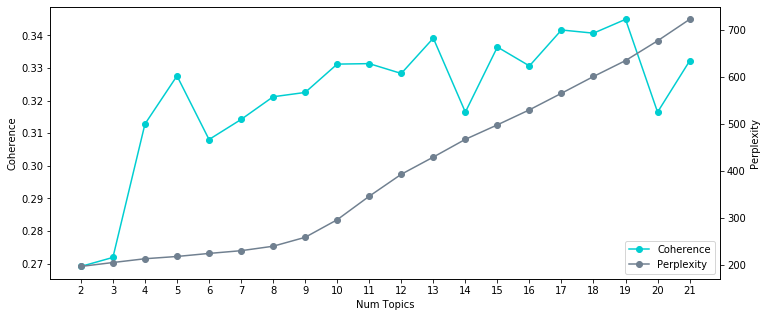

In [5]:
#Metrics for Topic Models
start = 2
limit = 22
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

# evaluation
x = range(start, limit, step)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot()

# coherence
ax1.plot(x, coherence_vals, 'o-', color='darkturquoise', label='Coherence')
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence')

# perplexity
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color='slategray', label='Perplexity')
ax2.set_ylabel('Perplexity')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

# Vis
ax1.set_xticks(x)
plt.show()

In [6]:
# トピック数の設定
NUM_TOPICS = 8

# モデル作成
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=0)

# データをモデルに掛ける
score_by_topic = defaultdict(int)

# クラスタリング結果を出力
cnt = 0
for unseen_doc, raw_text in zip(corpus, textDeta):
    print(raw_text, end='\n')
    for topic, score in lda_model[unseen_doc]:
        score_by_topic[int(topic)] = float(score)
    for i in range(NUM_TOPICS):
        print('{:.2f}'.format(score_by_topic[i]), end='\t')
    print("\n")
    cnt += 1
    if cnt > 10: break

平日ランチタイムの利用客が、毎回90%以上中高年女性なので、席の選択が可能な時は、男性客に選ばせて欲しい。女性客のど真ん中は、落ち着かない。
0.73	0.00	0.00	0.23	0.00	0.00	0.00	0.00	

黒ナンバーの車の廃車に関する問い合わせに男性の職員が出たが、口調が上からな感じで横柄な態度を取られた。売り言葉に買い言葉な雰囲気になりそうだったので、納得のいく回答が得られなかったがわかったフリをして用件を済ませた。女性を担当者にして欲しい。
0.73	0.12	0.00	0.23	0.66	0.00	0.10	0.10	

女性用のお箸はどうして男性ものより短く出来てるんですかぁ?
私は細くて男性ものぐらいの長さのお箸が好きなんだけど なかなかありません。
たまにあっても高価です。
女性って結構細くて長いお箸が好きな人が多いのになぁ〜
0.73	0.12	0.00	0.23	0.66	0.00	0.06	0.90	

職場の男性、若い女性にばかり優しく自分には冷たい。
話もアニメやゲーム好きで合わないのもあるが。
0.01	0.19	0.01	0.01	0.01	0.01	0.74	0.01	

看護師かは、はっきりしないが男性スタッフが増えている。女性は髪をまとめているが男性はボサボサの人が多い。外見だけでも清潔にして欲しい。
0.01	0.78	0.01	0.01	0.15	0.01	0.01	0.01	

夏目三久ちゃんでよかった( ́Д` )新しいあの方、異性受けはいいかもだけど、同性からは嫌われるタイプ(ー ー;)夏目三久ちゃんは老若男女受け入れられる。
0.01	0.01	0.01	0.01	0.01	0.25	0.68	0.01	

全く同じに作られていることが多いが、男性はリンス使わないし女性もシャンプーほどリンスは使わないのでどうしても同時に使い切らず、片方別メーカーを置くことになったりするのが不満...
ちょっとシャンプー多めに、リンスは少なめにしてくれないかなぁ
0.01	0.01	0.01	0.01	0.01	0.25	0.06	0.89	

ホットペッパービューティーで美容院毎回探すの大変。
男のスタイリストにやってもらうのが どうしても嫌で、できれば女性スタッフしかい美ない容院に行きたい。女性スタッフしかいない美容

### Words that belong to each topic with high probability

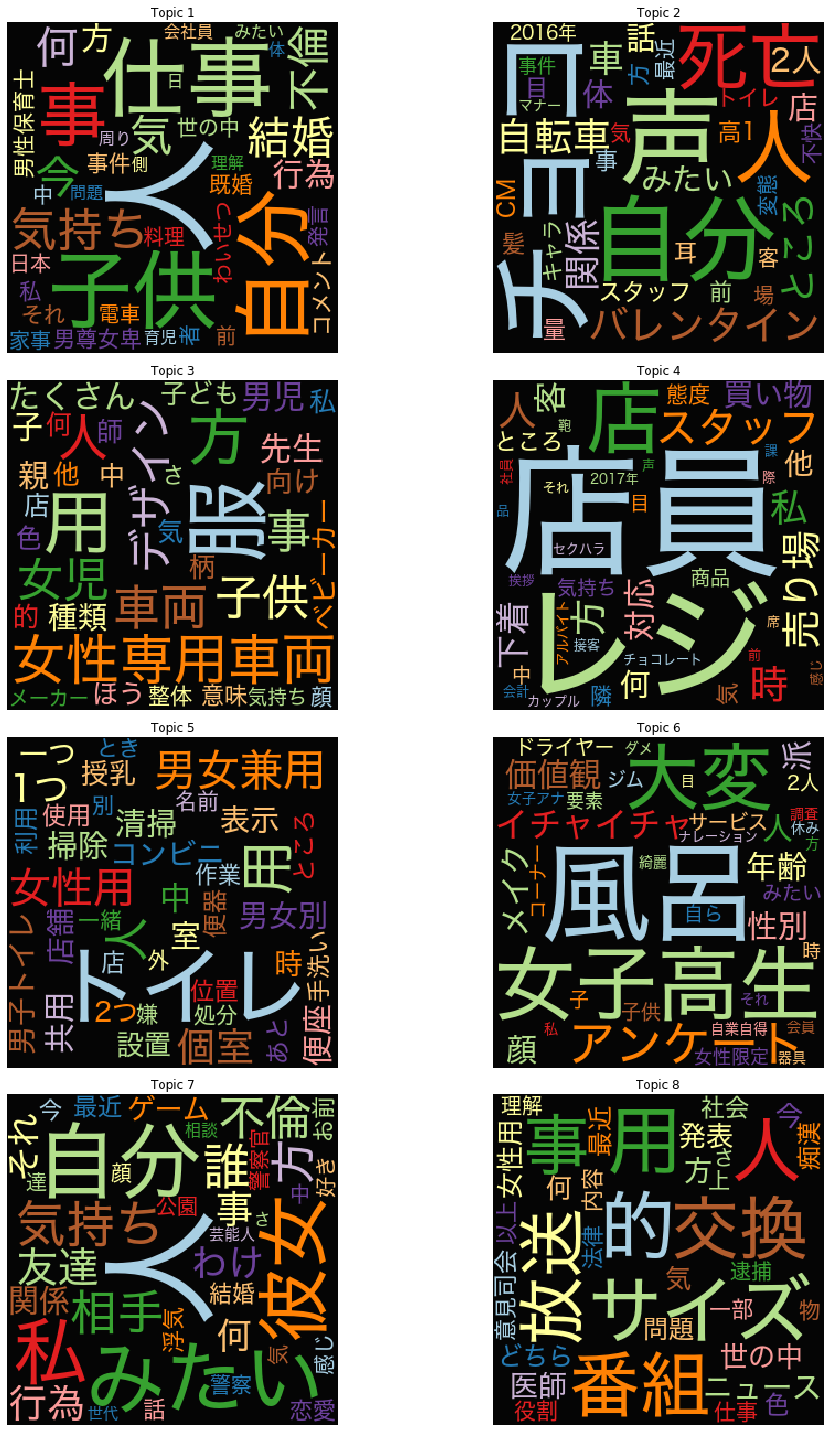

In [7]:
import math
from wordcloud import WordCloud

# WordCloud
fig, axs = plt.subplots(ncols=2, nrows=math.ceil(lda_model.num_topics/2), figsize=(16,20))
axs = axs.flatten()

stopwords=["不満", "男", "女", "男性", "女性", "男子", "女子", "男の子", "女の子", "男女", "の", "よう", "こと", "ん", "もの", "さん", "そう", "ため", "ごろ"]

for i in range(lda_model.num_topics):
    x = dict(lda_model.show_topic(i, 50))
    for s in stopwords:
        x.pop(s, None)
    im = WordCloud(
        background_color='black',
        font_path="/system/Library/Fonts/ヒラギノ角ゴシック W4.ttc",
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i+1))

# vis
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Vis PCoA
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

/opt/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [ ]:
import math
from wordcloud import WordCloud
from googletrans import Translator

# Translator
translator = Translator()

stopwords=["不満", "男", "女", "男性", "女性", "男子", "女子", "男の子", "女の子", "男女", "の", "よう", "こと", "ん", "もの", "さん", "そう", "ため", "ごろ", "みたい", "事", "人", "的", "方"]

for i in range(lda_model.num_topics):
    print("Topic " + str(i+1) + " :")
    x = dict(lda_model.show_topic(i, 50))
    for s in stopwords:
        x.pop(s, None)
    keys = [k for k, v in x.items()]
    cnt = 0
    while cnt < 5:
        trans_en = translator.translate(keys[cnt])
        print(str(cnt+1) + ":" + trans_en.text, keys[cnt])
        cnt+=1
    print()